In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
# sys.version

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

2024-08-07 15:30:09.295360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading the data

In [2]:
input_texts = []
target_texts = []

In [3]:
for line in open("../poetry_generator/data/robert_frost.txt"):
    line = line.rstrip()
    if not line:
        continue
        
    input_line = '<sos> ' + line
    target_line = line + ' <eos>'
    
    input_texts.append(input_line)
    target_texts.append(target_line)

In [4]:
all_lines = input_texts + target_texts
all_lines[:15]

['<sos> Two roads diverged in a yellow wood,',
 '<sos> And sorry I could not travel both',
 '<sos> And be one traveler, long I stood',
 '<sos> And looked down one as far as I could',
 '<sos> To where it bent in the undergrowth;',
 '<sos> Then took the other, as just as fair,',
 '<sos> And having perhaps the better claim',
 '<sos> Because it was grassy and wanted wear,',
 '<sos> Though as for that the passing there',
 '<sos> Had worn them really about the same,',
 '<sos> And both that morning equally lay',
 '<sos> In leaves no step had trodden black.',
 '<sos> Oh, I kept the first for another day!',
 '<sos> Yet knowing how way leads on to way',
 '<sos> I doubted if I should ever come back.']

In [5]:
len(all_lines)

2872

### Converting sentences into integers and word to integer mapping
#### Tokenizer 1) Splits into individual tokens/words 2) each word is converted into an integer index for mapping 

In [6]:
from keras.preprocessing.text import Tokenizer

MAX_VOCAB_SIZE = 3000
MAX_SEQUENCE_LENGTH = 100

In [7]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)

# converting words/texts in sentences into a sequence of integers
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

target_sequences[:15]

[[104, 537, 538, 9, 7, 539, 540, 2],
 [5, 541, 6, 65, 31, 934, 141, 2],
 [5, 27, 24, 935, 152, 6, 221, 2],
 [5, 167, 67, 24, 17, 128, 17, 6, 65, 2],
 [4, 40, 11, 936, 9, 3, 937, 2],
 [91, 189, 3, 542, 17, 77, 17, 938, 2],
 [5, 142, 265, 3, 222, 939, 2],
 [319, 11, 14, 543, 5, 223, 940, 2],
 [122, 17, 15, 13, 3, 544, 55, 2],
 [23, 545, 52, 404, 111, 3, 546, 2],
 [5, 141, 13, 941, 942, 405, 2],
 [9, 943, 42, 547, 23, 944, 548, 2],
 [549, 6, 266, 3, 224, 15, 267, 945, 2],
 [153, 946, 92, 81, 947, 18, 4, 81, 2],
 [6, 948, 28, 6, 123, 154, 78, 268, 2]]

In [8]:
print(input_sequences[:15])

max_seq_len_from_data = max(len(s) for s in input_sequences)
print('Maximum sequence length', max_seq_len_from_data)


[[1, 104, 537, 538, 9, 7, 539, 540], [1, 5, 541, 6, 65, 31, 934, 141], [1, 5, 27, 24, 935, 152, 6, 221], [1, 5, 167, 67, 24, 17, 128, 17, 6, 65], [1, 4, 40, 11, 936, 9, 3, 937], [1, 91, 189, 3, 542, 17, 77, 17, 938], [1, 5, 142, 265, 3, 222, 939], [1, 319, 11, 14, 543, 5, 223, 940], [1, 122, 17, 15, 13, 3, 544, 55], [1, 23, 545, 52, 404, 111, 3, 546], [1, 5, 141, 13, 941, 942, 405], [1, 9, 943, 42, 547, 23, 944, 548], [1, 549, 6, 266, 3, 224, 15, 267, 945], [1, 153, 946, 92, 81, 947, 18, 4, 81], [1, 6, 948, 28, 6, 123, 154, 78, 268]]
Maximum sequence length 12


#### word to integer mapping

In [9]:
word_to_index = tokenizer.word_index
print('unique tokens =',len(word_to_index))
assert('<sos>' in word_to_index)
assert('<eos>' in word_to_index)

unique tokens = 3056


### Padding sequences --> by adding padding tokens, all sequences of varying lengths have same length so that they can be effectively processed by the model

In [10]:
max_seq_len = min(max_seq_len_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_seq_len, padding='post')

In [11]:
print('Input sequence is {} with the size of {}' .format(input_sequences[0], input_sequences.shape[1]))
print('Target sequence is {} with the size of {}' .format(target_sequences[0], target_sequences.shape[1]))

Input sequence is [  1 104 537 538   9   7 539 540   0   0   0   0] with the size of 12
Target sequence is [104 537 538   9   7 539 540   2   0   0   0   0] with the size of 12


### Load pre-trained word vectors with GloVe and word --> vec mapping

In [12]:
path2glove = os.getcwd() + '/glove/glove.6B.50d.txt'

In [13]:
word2vec = {}
with open(path2glove) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        
    print('Found {} word vectors.' .format(len(word2vec)))

Found 400000 word vectors.


In [14]:
from itertools import islice

word2vec_first_3 = dict(islice(word2vec.items(), 3))

print(word2vec_first_3)

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32), ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
       -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
       -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
       -0.41634 , -0.1542

### Embedding matrix

In [15]:
print('Filling pretrained embeddings...')

Filling pretrained embeddings...


In [16]:
EMBEDDING_DIM = 50

num_words = min(MAX_VOCAB_SIZE, len(word_to_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [17]:
print(embedding_matrix.shape)
embedding_matrix

(3000, 50)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00

### One-hot encoded target 

#### The target is a sequence, so can not pass a sparse categorical cross entropy loss function to keras as I have multiple targets per input

In [19]:
print(input_sequences.shape)
print(max_seq_len)
print(num_words)

(1436, 12)
12
3000


In [20]:
one_hot_targets = np.zeros((len(input_sequences), max_seq_len, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [21]:
one_hot_targets[3][0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Load pre-trained word embeddings into an Embedding layer

In [22]:
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            weights=[embedding_matrix])

### 1) Training the language model to predict the next word in the sentence by memorizing a bunch of sentences..

### Create an LSTM network with a single LSTM

#### Building a model...

In [23]:
from keras.layers import Dense, Embedding, Input, LSTM

LATENT_DIM = 25
BATCH_SIZE = 128
EPOCHS = 1000
VALIDATION_SPLIT = 0.2

In [64]:
input_ = Input(shape = (max_seq_len,))
input_h = Input(shape = (LATENT_DIM,))
input_c = Input(shape = (LATENT_DIM,))

print(input_h.shape)

(None, 25)


In [26]:
x = embedding_layer(input_)

# LSTM has to predict rest of the sequence and the output must be a sequence, hence return_sequences=True
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[input_h, input_c])

dense = Dense(num_words, activation='softmax')
output = dense(x)

In [27]:
model = Model([input_, input_h, input_c], output)
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy'])

In [28]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit([input_sequences, z, z],
             one_hot_targets,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             validation_split=VALIDATION_SPLIT)

Training model...
Epoch 1/1000
9/9 [==============================] - 3s 173ms/step - loss: 5.3769 - accuracy: 0.0577 - val_loss: 5.0212 - val_accuracy: 0.0295
Epoch 2/1000
9/9 [==============================] - 1s 113ms/step - loss: 4.5902 - accuracy: 0.0706 - val_loss: 4.7406 - val_accuracy: 0.0833
Epoch 3/1000
9/9 [==============================] - 1s 107ms/step - loss: 4.3700 - accuracy: 0.0833 - val_loss: 4.7856 - val_accuracy: 0.0833
Epoch 4/1000
9/9 [==============================] - 1s 98ms/step - loss: 4.3249 - accuracy: 0.0833 - val_loss: 4.8072 - val_accuracy: 0.0833
Epoch 5/1000
9/9 [==============================] - 1s 96ms/step - loss: 4.3153 - accuracy: 0.0833 - val_loss: 4.8040 - val_accuracy: 0.0833
Epoch 6/1000
9/9 [==============================] - 1s 104ms/step - loss: 4.2923 - accuracy: 0.0833 - val_loss: 4.7679 - val_accuracy: 0.0833
Epoch 7/1000
9/9 [==============================] - 1s 101ms/step - loss: 4.2657 - accuracy: 0.0833 - val_loss: 4.7261 - val_accurac

9/9 [==============================] - 1s 97ms/step - loss: 2.9455 - accuracy: 0.1838 - val_loss: 4.8466 - val_accuracy: 0.0964
Epoch 59/1000
9/9 [==============================] - 1s 130ms/step - loss: 2.9265 - accuracy: 0.1848 - val_loss: 4.8519 - val_accuracy: 0.0972
Epoch 60/1000
9/9 [==============================] - 1s 95ms/step - loss: 2.9063 - accuracy: 0.1864 - val_loss: 4.8615 - val_accuracy: 0.0981
Epoch 61/1000
9/9 [==============================] - 1s 126ms/step - loss: 2.8883 - accuracy: 0.1880 - val_loss: 4.8761 - val_accuracy: 0.0978
Epoch 62/1000
9/9 [==============================] - 1s 121ms/step - loss: 2.8710 - accuracy: 0.1888 - val_loss: 4.8846 - val_accuracy: 0.0990
Epoch 63/1000
9/9 [==============================] - 1s 124ms/step - loss: 2.8505 - accuracy: 0.1911 - val_loss: 4.8914 - val_accuracy: 0.0981
Epoch 64/1000
9/9 [==============================] - 1s 114ms/step - loss: 2.8310 - accuracy: 0.1920 - val_loss: 4.9051 - val_accuracy: 0.0966
Epoch 65/1000
9

9/9 [==============================] - 1s 92ms/step - loss: 2.2549 - accuracy: 0.2605 - val_loss: 5.5798 - val_accuracy: 0.0877
Epoch 116/1000
9/9 [==============================] - 1s 91ms/step - loss: 2.2477 - accuracy: 0.2588 - val_loss: 5.5795 - val_accuracy: 0.0871
Epoch 117/1000
9/9 [==============================] - 1s 95ms/step - loss: 2.2393 - accuracy: 0.2615 - val_loss: 5.6045 - val_accuracy: 0.0883
Epoch 118/1000
9/9 [==============================] - 1s 97ms/step - loss: 2.2306 - accuracy: 0.2634 - val_loss: 5.6169 - val_accuracy: 0.0883
Epoch 119/1000
9/9 [==============================] - 1s 95ms/step - loss: 2.2221 - accuracy: 0.2636 - val_loss: 5.6441 - val_accuracy: 0.0894
Epoch 120/1000
9/9 [==============================] - 1s 95ms/step - loss: 2.2194 - accuracy: 0.2637 - val_loss: 5.6262 - val_accuracy: 0.0877
Epoch 121/1000
9/9 [==============================] - 1s 95ms/step - loss: 2.2068 - accuracy: 0.2635 - val_loss: 5.6654 - val_accuracy: 0.0865
Epoch 122/1000

9/9 [==============================] - 1s 98ms/step - loss: 1.8855 - accuracy: 0.3142 - val_loss: 6.5209 - val_accuracy: 0.0836
Epoch 173/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.8842 - accuracy: 0.3153 - val_loss: 6.4872 - val_accuracy: 0.0842
Epoch 174/1000
9/9 [==============================] - 1s 94ms/step - loss: 1.8810 - accuracy: 0.3144 - val_loss: 6.5541 - val_accuracy: 0.0828
Epoch 175/1000
9/9 [==============================] - 1s 95ms/step - loss: 1.8755 - accuracy: 0.3171 - val_loss: 6.5594 - val_accuracy: 0.0822
Epoch 176/1000
9/9 [==============================] - 1s 96ms/step - loss: 1.8728 - accuracy: 0.3174 - val_loss: 6.5503 - val_accuracy: 0.0842
Epoch 177/1000
9/9 [==============================] - 1s 91ms/step - loss: 1.8653 - accuracy: 0.3184 - val_loss: 6.5662 - val_accuracy: 0.0833
Epoch 178/1000
9/9 [==============================] - 1s 95ms/step - loss: 1.8600 - accuracy: 0.3191 - val_loss: 6.6184 - val_accuracy: 0.0848
Epoch 179/1000

9/9 [==============================] - 1s 108ms/step - loss: 1.6499 - accuracy: 0.3608 - val_loss: 7.4902 - val_accuracy: 0.0770
Epoch 230/1000
9/9 [==============================] - 1s 103ms/step - loss: 1.6440 - accuracy: 0.3622 - val_loss: 7.5155 - val_accuracy: 0.0787
Epoch 231/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.6381 - accuracy: 0.3630 - val_loss: 7.5393 - val_accuracy: 0.0761
Epoch 232/1000
9/9 [==============================] - 1s 118ms/step - loss: 1.6337 - accuracy: 0.3647 - val_loss: 7.5716 - val_accuracy: 0.0758
Epoch 233/1000
9/9 [==============================] - 1s 102ms/step - loss: 1.6303 - accuracy: 0.3654 - val_loss: 7.5911 - val_accuracy: 0.0778
Epoch 234/1000
9/9 [==============================] - 1s 102ms/step - loss: 1.6285 - accuracy: 0.3663 - val_loss: 7.5862 - val_accuracy: 0.0755
Epoch 235/1000
9/9 [==============================] - 1s 98ms/step - loss: 1.6249 - accuracy: 0.3659 - val_loss: 7.6087 - val_accuracy: 0.0758
Epoch 23

9/9 [==============================] - 1s 100ms/step - loss: 1.4915 - accuracy: 0.3902 - val_loss: 8.4747 - val_accuracy: 0.0749
Epoch 287/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.4871 - accuracy: 0.3894 - val_loss: 8.5042 - val_accuracy: 0.0744
Epoch 288/1000
9/9 [==============================] - 1s 97ms/step - loss: 1.4873 - accuracy: 0.3879 - val_loss: 8.5544 - val_accuracy: 0.0749
Epoch 289/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.4862 - accuracy: 0.3908 - val_loss: 8.5244 - val_accuracy: 0.0744
Epoch 290/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.4812 - accuracy: 0.3918 - val_loss: 8.5684 - val_accuracy: 0.0732
Epoch 291/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.4790 - accuracy: 0.3912 - val_loss: 8.6042 - val_accuracy: 0.0744
Epoch 292/1000
9/9 [==============================] - 1s 122ms/step - loss: 1.4775 - accuracy: 0.3924 - val_loss: 8.5967 - val_accuracy: 0.0738
Epoch 29

9/9 [==============================] - 1s 104ms/step - loss: 1.3864 - accuracy: 0.4097 - val_loss: 9.5699 - val_accuracy: 0.0712
Epoch 344/1000
9/9 [==============================] - 1s 124ms/step - loss: 1.3819 - accuracy: 0.4081 - val_loss: 9.5877 - val_accuracy: 0.0729
Epoch 345/1000
9/9 [==============================] - 1s 116ms/step - loss: 1.3741 - accuracy: 0.4113 - val_loss: 9.5651 - val_accuracy: 0.0712
Epoch 346/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.3827 - accuracy: 0.4102 - val_loss: 9.5937 - val_accuracy: 0.0735
Epoch 347/1000
9/9 [==============================] - 1s 107ms/step - loss: 1.3860 - accuracy: 0.4079 - val_loss: 9.6286 - val_accuracy: 0.0715
Epoch 348/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.3770 - accuracy: 0.4110 - val_loss: 9.6409 - val_accuracy: 0.0720
Epoch 349/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.3840 - accuracy: 0.4096 - val_loss: 9.6323 - val_accuracy: 0.0709
Epoch 3

Epoch 400/1000
9/9 [==============================] - 1s 96ms/step - loss: 1.3071 - accuracy: 0.4254 - val_loss: 10.5710 - val_accuracy: 0.0683
Epoch 401/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.2999 - accuracy: 0.4297 - val_loss: 10.6246 - val_accuracy: 0.0674
Epoch 402/1000
9/9 [==============================] - 1s 102ms/step - loss: 1.3056 - accuracy: 0.4257 - val_loss: 10.6715 - val_accuracy: 0.0666
Epoch 403/1000
9/9 [==============================] - 1s 106ms/step - loss: 1.3163 - accuracy: 0.4244 - val_loss: 10.6944 - val_accuracy: 0.0677
Epoch 404/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.3205 - accuracy: 0.4209 - val_loss: 10.6534 - val_accuracy: 0.0694
Epoch 405/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.3118 - accuracy: 0.4235 - val_loss: 10.6965 - val_accuracy: 0.0680
Epoch 406/1000
9/9 [==============================] - 1s 102ms/step - loss: 1.3202 - accuracy: 0.4227 - val_loss: 10.7511 - val_acc

9/9 [==============================] - 1s 100ms/step - loss: 1.2559 - accuracy: 0.4379 - val_loss: 11.6513 - val_accuracy: 0.0668
Epoch 457/1000
9/9 [==============================] - 1s 102ms/step - loss: 1.2590 - accuracy: 0.4367 - val_loss: 11.7225 - val_accuracy: 0.0663
Epoch 458/1000
9/9 [==============================] - 1s 119ms/step - loss: 1.2636 - accuracy: 0.4360 - val_loss: 11.7662 - val_accuracy: 0.0689
Epoch 459/1000
9/9 [==============================] - 1s 96ms/step - loss: 1.2659 - accuracy: 0.4332 - val_loss: 11.7371 - val_accuracy: 0.0674
Epoch 460/1000
9/9 [==============================] - 1s 97ms/step - loss: 1.2684 - accuracy: 0.4326 - val_loss: 11.7725 - val_accuracy: 0.0683
Epoch 461/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.2705 - accuracy: 0.4307 - val_loss: 11.7998 - val_accuracy: 0.0648
Epoch 462/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.2645 - accuracy: 0.4347 - val_loss: 11.7794 - val_accuracy: 0.0677
Ep

Epoch 513/1000
9/9 [==============================] - 1s 115ms/step - loss: 1.2159 - accuracy: 0.4461 - val_loss: 12.7604 - val_accuracy: 0.0689
Epoch 514/1000
9/9 [==============================] - 1s 106ms/step - loss: 1.2184 - accuracy: 0.4405 - val_loss: 12.7325 - val_accuracy: 0.0660
Epoch 515/1000
9/9 [==============================] - 1s 104ms/step - loss: 1.2159 - accuracy: 0.4437 - val_loss: 12.7578 - val_accuracy: 0.0686
Epoch 516/1000
9/9 [==============================] - 1s 103ms/step - loss: 1.2116 - accuracy: 0.4443 - val_loss: 12.7886 - val_accuracy: 0.0683
Epoch 517/1000
9/9 [==============================] - 1s 98ms/step - loss: 1.2122 - accuracy: 0.4446 - val_loss: 12.8608 - val_accuracy: 0.0674
Epoch 518/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.2197 - accuracy: 0.4428 - val_loss: 12.7849 - val_accuracy: 0.0677
Epoch 519/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.2134 - accuracy: 0.4443 - val_loss: 12.8485 - val_accur

9/9 [==============================] - 1s 104ms/step - loss: 1.1732 - accuracy: 0.4517 - val_loss: 13.8950 - val_accuracy: 0.0642
Epoch 570/1000
9/9 [==============================] - 1s 126ms/step - loss: 1.1764 - accuracy: 0.4495 - val_loss: 13.8682 - val_accuracy: 0.0651
Epoch 571/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.1843 - accuracy: 0.4503 - val_loss: 13.8846 - val_accuracy: 0.0663
Epoch 572/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.1894 - accuracy: 0.4482 - val_loss: 13.7911 - val_accuracy: 0.0654
Epoch 573/1000
9/9 [==============================] - 1s 97ms/step - loss: 1.1955 - accuracy: 0.4448 - val_loss: 13.8661 - val_accuracy: 0.0660
Epoch 574/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.1968 - accuracy: 0.4480 - val_loss: 13.9445 - val_accuracy: 0.0666
Epoch 575/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.1844 - accuracy: 0.4492 - val_loss: 13.9555 - val_accuracy: 0.0668
Ep

Epoch 626/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.1489 - accuracy: 0.4573 - val_loss: 14.7681 - val_accuracy: 0.0654
Epoch 627/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.1456 - accuracy: 0.4562 - val_loss: 14.8172 - val_accuracy: 0.0660
Epoch 628/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.1431 - accuracy: 0.4566 - val_loss: 14.7589 - val_accuracy: 0.0660
Epoch 629/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.1432 - accuracy: 0.4591 - val_loss: 14.8188 - val_accuracy: 0.0648
Epoch 630/1000
9/9 [==============================] - 1s 97ms/step - loss: 1.1387 - accuracy: 0.4598 - val_loss: 14.8472 - val_accuracy: 0.0657
Epoch 631/1000
9/9 [==============================] - 1s 98ms/step - loss: 1.1346 - accuracy: 0.4596 - val_loss: 14.8860 - val_accuracy: 0.0645
Epoch 632/1000
9/9 [==============================] - 1s 103ms/step - loss: 1.1298 - accuracy: 0.4609 - val_loss: 14.8369 - val_accur

9/9 [==============================] - 1s 102ms/step - loss: 1.1195 - accuracy: 0.4599 - val_loss: 15.6076 - val_accuracy: 0.0660
Epoch 683/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.1201 - accuracy: 0.4629 - val_loss: 15.6986 - val_accuracy: 0.0648
Epoch 684/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.1270 - accuracy: 0.4575 - val_loss: 15.7210 - val_accuracy: 0.0654
Epoch 685/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.1143 - accuracy: 0.4638 - val_loss: 15.7348 - val_accuracy: 0.0642
Epoch 686/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.1125 - accuracy: 0.4632 - val_loss: 15.7547 - val_accuracy: 0.0645
Epoch 687/1000
9/9 [==============================] - 1s 102ms/step - loss: 1.1127 - accuracy: 0.4645 - val_loss: 15.7628 - val_accuracy: 0.0651
Epoch 688/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.1118 - accuracy: 0.4636 - val_loss: 15.7619 - val_accuracy: 0.0654
Epo

Epoch 739/1000
9/9 [==============================] - 1s 103ms/step - loss: 1.0952 - accuracy: 0.4679 - val_loss: 16.6519 - val_accuracy: 0.0668
Epoch 740/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.0898 - accuracy: 0.4691 - val_loss: 16.5709 - val_accuracy: 0.0654
Epoch 741/1000
9/9 [==============================] - 1s 100ms/step - loss: 1.0845 - accuracy: 0.4711 - val_loss: 16.6679 - val_accuracy: 0.0657
Epoch 742/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.0896 - accuracy: 0.4664 - val_loss: 16.6851 - val_accuracy: 0.0666
Epoch 743/1000
9/9 [==============================] - 1s 98ms/step - loss: 1.1001 - accuracy: 0.4669 - val_loss: 16.6882 - val_accuracy: 0.0666
Epoch 744/1000
9/9 [==============================] - 1s 98ms/step - loss: 1.0955 - accuracy: 0.4683 - val_loss: 16.7315 - val_accuracy: 0.0668
Epoch 745/1000
9/9 [==============================] - 1s 103ms/step - loss: 1.0992 - accuracy: 0.4673 - val_loss: 16.6350 - val_accur

9/9 [==============================] - 1s 122ms/step - loss: 1.0671 - accuracy: 0.4734 - val_loss: 17.5633 - val_accuracy: 0.0637
Epoch 796/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.0697 - accuracy: 0.4763 - val_loss: 17.5184 - val_accuracy: 0.0651
Epoch 797/1000
9/9 [==============================] - 1s 107ms/step - loss: 1.0753 - accuracy: 0.4720 - val_loss: 17.4798 - val_accuracy: 0.0666
Epoch 798/1000
9/9 [==============================] - 1s 101ms/step - loss: 1.0786 - accuracy: 0.4686 - val_loss: 17.6026 - val_accuracy: 0.0637
Epoch 799/1000
9/9 [==============================] - 1s 121ms/step - loss: 1.0788 - accuracy: 0.4700 - val_loss: 17.5977 - val_accuracy: 0.0639
Epoch 800/1000
9/9 [==============================] - 1s 99ms/step - loss: 1.0742 - accuracy: 0.4731 - val_loss: 17.6282 - val_accuracy: 0.0642
Epoch 801/1000
9/9 [==============================] - 1s 107ms/step - loss: 1.0650 - accuracy: 0.4756 - val_loss: 17.6503 - val_accuracy: 0.0666
E

9/9 [==============================] - 1s 107ms/step - loss: 1.0663 - accuracy: 0.4733 - val_loss: 18.3603 - val_accuracy: 0.0660
Epoch 852/1000
9/9 [==============================] - 1s 127ms/step - loss: 1.0671 - accuracy: 0.4735 - val_loss: 18.3923 - val_accuracy: 0.0666
Epoch 853/1000
9/9 [==============================] - 1s 104ms/step - loss: 1.0631 - accuracy: 0.4721 - val_loss: 18.4945 - val_accuracy: 0.0648
Epoch 854/1000
9/9 [==============================] - 1s 112ms/step - loss: 1.0582 - accuracy: 0.4747 - val_loss: 18.4074 - val_accuracy: 0.0666
Epoch 855/1000
9/9 [==============================] - 1s 109ms/step - loss: 1.0548 - accuracy: 0.4755 - val_loss: 18.3764 - val_accuracy: 0.0660
Epoch 856/1000
9/9 [==============================] - 1s 129ms/step - loss: 1.0498 - accuracy: 0.4766 - val_loss: 18.4871 - val_accuracy: 0.0671
Epoch 857/1000
9/9 [==============================] - 1s 107ms/step - loss: 1.0526 - accuracy: 0.4754 - val_loss: 18.5612 - val_accuracy: 0.0651


Epoch 908/1000
9/9 [==============================] - 1s 95ms/step - loss: 1.0564 - accuracy: 0.4734 - val_loss: 19.3005 - val_accuracy: 0.0668
Epoch 909/1000
9/9 [==============================] - 1s 98ms/step - loss: 1.0461 - accuracy: 0.4766 - val_loss: 19.2308 - val_accuracy: 0.0648
Epoch 910/1000
9/9 [==============================] - 1s 103ms/step - loss: 1.0492 - accuracy: 0.4773 - val_loss: 19.2324 - val_accuracy: 0.0651
Epoch 911/1000
9/9 [==============================] - 1s 97ms/step - loss: 1.0521 - accuracy: 0.4768 - val_loss: 19.3427 - val_accuracy: 0.0654
Epoch 912/1000
9/9 [==============================] - 1s 109ms/step - loss: 1.0547 - accuracy: 0.4744 - val_loss: 19.3361 - val_accuracy: 0.0660
Epoch 913/1000
9/9 [==============================] - 1s 129ms/step - loss: 1.0619 - accuracy: 0.4714 - val_loss: 19.3354 - val_accuracy: 0.0666
Epoch 914/1000
9/9 [==============================] - 1s 122ms/step - loss: 1.0564 - accuracy: 0.4758 - val_loss: 19.3607 - val_accur

9/9 [==============================] - 1s 99ms/step - loss: 1.0501 - accuracy: 0.4734 - val_loss: 20.1088 - val_accuracy: 0.0645
Epoch 965/1000
9/9 [==============================] - 1s 94ms/step - loss: 1.0525 - accuracy: 0.4750 - val_loss: 20.0574 - val_accuracy: 0.0648
Epoch 966/1000
9/9 [==============================] - 1s 92ms/step - loss: 1.0557 - accuracy: 0.4706 - val_loss: 20.1070 - val_accuracy: 0.0648
Epoch 967/1000
9/9 [==============================] - 1s 94ms/step - loss: 1.0459 - accuracy: 0.4726 - val_loss: 20.0795 - val_accuracy: 0.0657
Epoch 968/1000
9/9 [==============================] - 1s 96ms/step - loss: 1.0389 - accuracy: 0.4750 - val_loss: 20.0756 - val_accuracy: 0.0651
Epoch 969/1000
9/9 [==============================] - 1s 96ms/step - loss: 1.0508 - accuracy: 0.4753 - val_loss: 20.1846 - val_accuracy: 0.0654
Epoch 970/1000
9/9 [==============================] - 1s 95ms/step - loss: 1.0371 - accuracy: 0.4771 - val_loss: 20.1397 - val_accuracy: 0.0668
Epoch 9

### Plotting 
#### 1) loss vs val_loss and 2) accuracy vs val_accuracy

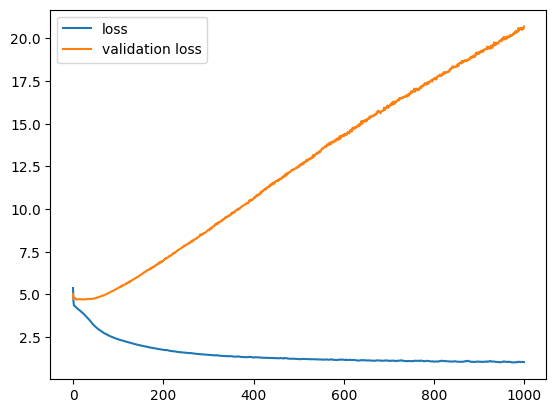

In [29]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

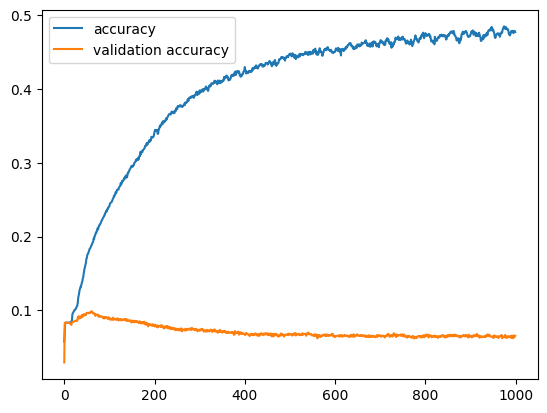

In [30]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [31]:
### 1) Trained the language model to predict the next word in the sentence by memorizing a bunch of sentences.
### 2) Using this trained language model, I will be generating new sentences, poetry

### Decoder

In [32]:
input2 = Input(shape=(1,))

x = embedding_layer(input2)

x, h, c = lstm(x, initial_state=[input_h, input_c])

output2 = dense(x)

sampling_model = Model([input2, input_h, input_c], [output2, h, c])

#### Index to word mapping

In [33]:
idx_to_word = {idx:w for w, idx in word_to_index.items()}
idx_to_word

{1: '<sos>',
 2: '<eos>',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'i',
 7: 'a',
 8: 'of',
 9: 'in',
 10: 'you',
 11: 'it',
 12: 'he',
 13: 'that',
 14: 'was',
 15: 'for',
 16: 'but',
 17: 'as',
 18: 'on',
 19: 'with',
 20: 'what',
 21: 'all',
 22: 'they',
 23: 'had',
 24: 'one',
 25: 'me',
 26: 'his',
 27: 'be',
 28: 'if',
 29: 'have',
 30: 'we',
 31: 'not',
 32: 'is',
 33: 'from',
 34: 'she',
 35: 'up',
 36: 'out',
 37: 'like',
 38: 'see',
 39: 'or',
 40: 'where',
 41: 'at',
 42: 'no',
 43: 'when',
 44: 'my',
 45: 'her',
 46: 'so',
 47: 'by',
 48: 'some',
 49: "it's",
 50: 'him',
 51: "don't",
 52: 'them',
 53: 'this',
 54: 'were',
 55: 'there',
 56: 'been',
 57: 'can',
 58: 'too',
 59: 'are',
 60: 'tell',
 61: "he's",
 62: 'do',
 63: 'old',
 64: "'i",
 65: 'could',
 66: 'know',
 67: 'down',
 68: 'here',
 69: 'an',
 70: 'off',
 71: 'your',
 72: 'think',
 73: 'must',
 74: 'only',
 75: 'make',
 76: 'let',
 77: 'just',
 78: 'come',
 79: 'will',
 80: 'would',
 81: 'way',
 82: 'made',
 83: 'sa

In [62]:
def sample_line():
    np_input = np.array([[word_to_index['<sos>']]])
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM)) 

    eos = word_to_index['<eos>']

    output_sentence = []

    for _ in range(max_seq_len):
        o, h, c = sampling_model.predict([np_input, h, c])
        probs = o[0,0]
        if np.argmax(probs) == 0:
            print("holy")
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break

        output_sentence.append(idx_to_word.get(idx, '<HOLY %s>' % idx))

        np_input[0,0] = idx

    return ' '.join(output_sentence)

#### Generating 4 lines of poem

In [65]:
while True:
    for _ in range(4):
        print(sample_line())
        
    ans = input("---Generate another line? [Y/n] ---")
    if ans and ans[0].lower().startswith('n'):
        break

1/1 [==============================] - 0s 18ms/step
still said to haunt this side of panther mountain.
1/1 [==============================] - 0s 21ms/step
the faintest restless rustling ran all through lajway.
1/1 [==============================] - 0s 26ms/step
>from the hall to the only finished bedroom, cellar.
1/1 [==============================] - 0s 18ms/step
and bring a pound,
---Generate another line? [Y/n] ---y
1/1 [==============================] - 0s 18ms/step
you don't give recognize seeking spilled feet them to plain speaking.
1/1 [==============================] - 0s 18ms/step
bless you, it purport troubling groping where if.
1/1 [==============================] - 0s 18ms/step
the chisel work fill hudson's to pass a winter eve.
1/1 [==============================] - 0s 19ms/step
he's celebrating something strange.
---Generate another line? [Y/n] ---n
